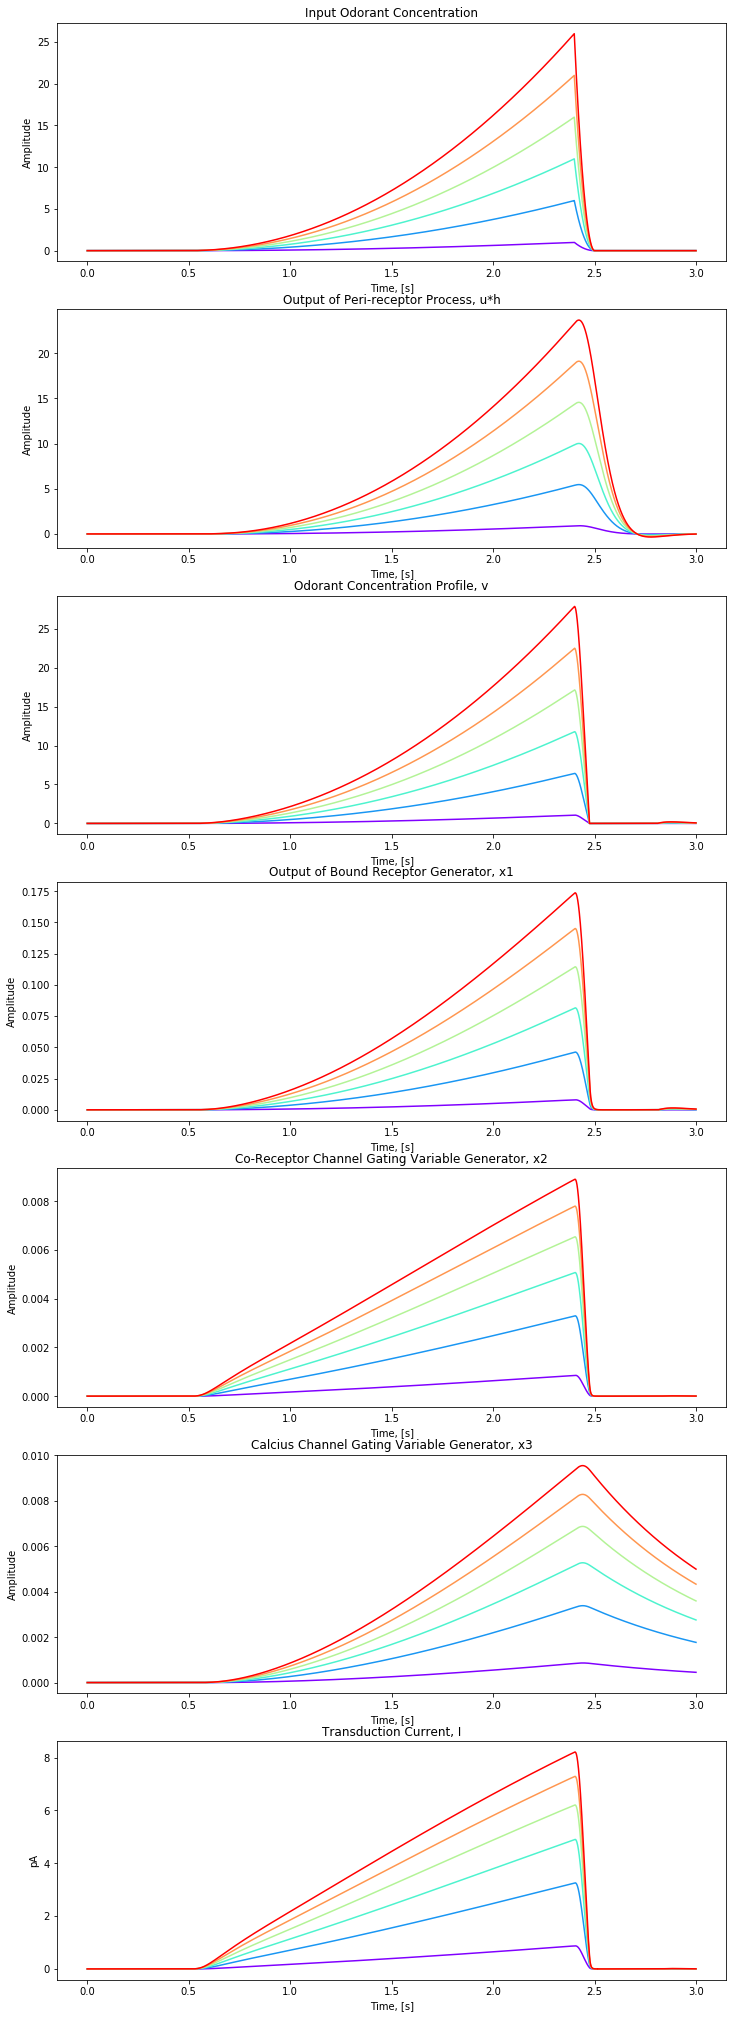

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler

### Define Constants (same as paper)
alpha_1 = 1.57e1
beta_1 = 8.00e-1
gamma_ron = 1.75e-1
alpha_2 = 8.877e1
beta_2 = 9.789e1
alpha_3 = 2.100e0
beta_3 = 1.2e0
kappa = 7.089e3
c = 7.534e-2
p = 1.0
I_max = 7.774e1

### Define R, O, N
R = 1
O = 1
N = 6

### Define time axis
t_step = 1e-4
t_duration = 3.0
t_range = np.arange(0,t_duration,t_step)

### The helper function for the peri-receptor process
def filter_h(alpha, beta, t_range, R, O, N, stimulus = 'parabola', form = 'intensity'):
    t_steps = len(t_range)
    t_step = t_range[1] - t_range[0]
    x_1 = np.zeros((t_steps,R,O,N))
    x_2 = np.zeros((t_steps,R,O,N))
    u = np.zeros((t_steps,R,O,N))
    if stimulus == 'constant':
        for i in range(N):
            u = u + 5. * i
    if stimulus == 'step':
        for i in range(N):
            u[(t_range>=0.5) * (t_range<=2.5),:,:,i] += 1. + 5. * i
    if stimulus == 'ramp':
        for i in range(N):
            A = 1 if N == 0 else N * 20
            x = A/1.8 * (t_range - 0.5) * (t_range>=0.5) * (t_range<=2.3) + (1. + 5. * i) * (1 - 5*(t_range - 2.3)) * (t_range>2.3) * (t_range<=2.5)
            x = np.reshape(x, (len(x), 1, 1))
            x = np.repeat(x, R, axis = 1)
            x = np.repeat(x, O, axis = 2)
            u[:,:,:,i] += x
    if stimulus == 'parabola':
        for i in range(N):
            x = (1. + 5. * i) * ((t_range - 0.5)/1.9)**2.0 * (t_range>=0.5) * (t_range<=2.4) + (1. + 5. * i) * (1 - 10*(t_range - 2.4))**2. * (t_range>2.4) * (t_range<=2.5)
            x = np.reshape(x, (len(x), 1, 1))
            x = np.repeat(x, R, axis = 1)
            x = np.repeat(x, O, axis = 2)
            u[:,:,:,i] += x
    if form == 'gradient':
        u[:-1] = (u[1:] - u[:-1]) / t_step
        u[-1] = u[-1] * 0.
        #u = np.maximum(0., u)
    for i in range(t_steps-1):
        dx_1 = x_2[i,:,:,:]
        dx_2 = alpha * alpha * (u[i,:,:,:] - x_1[i,:,:,:]) - 2 * alpha * beta * x_2[i,:,:,:]
        dx_1[np.isnan(dx_1)] = 0.
        dx_2[np.isnan(dx_2)] = 0.
        x_2[i+1,:,:,:] = x_2[i,:,:,:] + t_step * dx_2
        x_1[i+1,:,:,:] = x_1[i,:,:,:] + t_step * dx_1
    return u, x_1

### Main callable function for the OTP model
def otp_model(alpha_1, beta_1, R, O, N, gamma_ron, t_range, b, d, alpha_2, beta_2, kappa, alpha_3, beta_3, c, p, I_max, stimulus, filter_h = filter_h):
    u, u_h = filter_h(alpha_1, beta_1, t_range, R, O, N, stimulus = stimulus)
    unused, u_h_grad = filter_h(alpha_1, beta_1, t_range, R, O, N, stimulus = stimulus, form = 'gradient')
    v = np.maximum(0., u_h + u_h_grad * gamma_ron)
    b = v * 0.0 + b
    d = v * 0.0 + d
    
    t_steps = len(t_range)
    t_step = t_range[1] - t_range[0]
    x_1 = v * 0.0
    x_2 = v * 0.0
    x_3 = v * 0.0
    I = v * 0.0
    for i in range(t_steps-1):
        dx_1 = b[i,:,:,:] * v[i,:,:,:] * (1. - x_1[i,:,:,:]) - d[i,:,:,:] * x_1[i,:,:,:]
        dx_2 = alpha_2 * x_1[i,:,:,:] * (1. - x_2[i,:,:,:]) - beta_2 * x_2[i,:,:,:] - kappa * np.power(np.maximum(x_2[i,:,:,:], 0), 0.66) * np.power(x_3[i,:,:,:], 0.66)
        dx_3 = alpha_3 * x_2[i,:,:,:] - beta_3 * x_3[i,:,:,:]
        dx_1[np.isnan(dx_1)] = 0.
        dx_2[np.isnan(dx_2)] = 0.
        dx_3[np.isnan(dx_3)] = 0.
        x_1[i+1,:,:,:] = x_1[i,:,:,:] + t_step * dx_1
        x_2[i+1,:,:,:] = x_2[i,:,:,:] + t_step * dx_2
        x_3[i+1,:,:,:] = x_3[i,:,:,:] + t_step * dx_3
    I = x_2 / (x_2 + c ** p) * I_max
    return u, u_h, v, x_1, x_2, x_3, I

# Example
u, u_h, v, x_1, x_2, x_3, I = otp_model(alpha_1, beta_1, R, O, N, gamma_ron, t_range, 1., 132., alpha_2, beta_2, kappa, alpha_3, beta_3, c, p, I_max, stimulus = "parabola")
cmap = plt.cm.rainbow
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))


fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(12, 36))
for i in range(N):
    ax1.plot(t_range, u[:,:,:,i][:,0][:,0])
    ax2.plot(t_range, u_h[:,:,:,i][:,0][:,0])
    ax3.plot(t_range, v[:,:,:,i][:,0][:,0])
    ax4.plot(t_range, x_1[:,:,:,i][:,0][:,0])
    ax5.plot(t_range, x_2[:,:,:,i][:,0][:,0])
    ax6.plot(t_range, x_3[:,:,:,i][:,0][:,0])
    ax7.plot(t_range, I[:,:,:,i][:,0][:,0])

ax1.set_title("Input Odorant Concentration")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Time, [s]")

ax2.set_title("Output of Peri-receptor Process, u*h")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Time, [s]")

ax3.set_title("Odorant Concentration Profile, v")
ax3.set_ylabel("Amplitude")
ax3.set_xlabel("Time, [s]")

ax4.set_title("Output of Bound Receptor Generator, x1")
ax4.set_ylabel("Amplitude")
ax4.set_xlabel("Time, [s]")

ax5.set_title("Co-Receptor Channel Gating Variable Generator, x2")
ax5.set_ylabel("Amplitude")
ax5.set_xlabel("Time, [s]")

ax6.set_title("Calcius Channel Gating Variable Generator, x3")
ax6.set_ylabel("Amplitude")
ax6.set_xlabel("Time, [s]")

ax7.set_title("Transduction Current, I")
ax7.set_ylabel("pA")
ax7.set_xlabel("Time, [s]")

plt.show()


In [ ]:
import numpy as np
import sys
import pandas as pd
import copy

def LD_to_DL(LD):
     return dict(zip(LD[0],zip(*[d.values() for d in LD])))

def zo(x):
    return np.minimum(np.maximum(0., x), 1.)

""" I/O Conversion Functions
    --------
    The following functions handle the conversion of numpy arrays into lists and back. 
    This behavior is useful if you are going to be primarily using numpy in your code.
    For behavior consistent with the docstring replace these with identity functions 
    as shown.
"""
def get_columns(x):
    return [column.T for column in x.T]
    # return x # For default docstring behavior

def return_columns(x):
    return np.vstack(x).T
    # return x # For default docstring behavior

""" State and Input Name Dictionaries
    --------
    The following dictionaries are helpful for building a simulator and keeping track of the ordering of the variables.
"""

SN = {} # State name dictionary
SN['HH_step'] = ['V', 'n', 'm', 'h', 'spike', 'Vprev1', 'Vprev2']
SN['CS_step'] = ['V', 'n', 'm', 'h', 'a', 'b', 'spike', 'Vprev1', 'Vprev2']
SN['ML_step'] = ['V', 'R', 'spike', 'Vprev1', 'Vprev2']
SN['IonotropicSynapse_step'] = ['g_syn', 'x1']
SN['MetabotropicSynapse_step'] = ['g_syn', 'x1', 'x2']
SN['Dendrite_step'] = ['I']
SN['ConstantCurrent_step'] = ['I']

IN = {} # Input name dictionary
IN['HH_step'] = ['I']
IN['CS_step'] = ['I']
IN['ML_step'] = ['I']
IN['IonotropicSynapse_step'] = ['spike']
IN['MetabotropicSynapse_step'] = ['spike']
IN['Dendrite_step'] = ['g_syn', 'V']
IN['ConstantCurrent_step'] = ['I']

""" Model Step Functions
    --------
    Step functions for various models.
"""

def HH_step(dt, I, x):
    """Step function for a Hodgkin-Huxley neuron

    Parameters
    --------
    dt: float
        Time step in seconds
    I: float
        Injected current
    x: list
        State list, containing:
        V: float
            Current voltage
        n: float
            Current state variable value
        m: float
            Current state variable value
        h: float
            Current state variable value
        spike: float
            Current binary spike state
        Vprev1: float
            Voltage 1 time step ago
        Vprev2: float
            Voltage 2 time steps ago

    Returns
    -------
    x: list
        Updated state list.
    """
    
    dt = dt * 1000.
    I = get_columns(I)[0]
    V, n, m, h, spike, Vprev1, Vprev2 = get_columns(x)

    n = zo(n)
    m = zo(m)
    h = zo(h)
    
    E_K = -77
    E_Na = 50
    E_L = -54.387
    gmax_K = 36
    gmax_Na = 120
    g_L = 0.3
    
    an = 0.01*(V+55)/(1-np.exp(-0.1*(V+55)))
    bn = 0.125*np.exp(-(V+65)/80)
    

    am = 0.1*(V+40)/(1-np.exp(-0.1*(V+40)))
    bm = 4*np.exp(-(V+65)/18)
    
    
    ah = 0.07*np.exp(-0.05*(V+65))
    bh = 1/(1+np.exp(-0.1*(V+35)))
    
    # Update internal state variables
    dn = (an*(1.-n)-bn*n)
    dm = (am*(1.-m)-bm*m)
    dh = (ah*(1.-h)-bh*h)
    '''
    dm[np.isnan(dm)] = 0.
    dn[np.isnan(dn)] = 0.
    dh[np.isnan(dh)] = 0.
    '''
    
    # Calculate the memconductances
    g_K = gmax_K*(n**4.)
    g_Na = gmax_Na*(m**3.)*h
    
    # Update the ionic currents: and membrane voltage:
    I_K = g_K*(V-E_K)
    I_Na = g_Na*(V-E_Na)
    I_L = g_L*(V-E_L)
    
    # Calculate the gradients
    dV = I-I_K-I_Na-I_L
    dV[np.isnan(dV)] = 0.
    spike = (Vprev2<=Vprev1) * (Vprev1 >= V) * (Vprev1 > -30)

    x = [V+dt*dV, n+dt*dn, m+dt*dm, h+dt*dh, spike, V+dt*dV, Vprev1]

    return return_columns(x)

def CS_step(dt, I, x): 
    """Step function for a Connor-Stevens neuron

    Parameters
    --------
    dt: float
        Time step in seconds
    I: float
        Injected current
    x: list
        State list, containing:
        V: float
            Current voltage
        n: float
            Current state variable value
        m: float
            Current state variable value
        h: float
            Current state variable value
        a: float
            Current state variable value
        b: float
            Current state variable value
        spike: float
            Current binary spike state
        Vprev1: float
            Voltage 1 time step ago
        Vprev2: float
            Voltage 2 time steps ago
    Returns
    -------
    x: list
        Updated state list.
    """

    dt = dt * 1000.
    I = get_columns(I)[0]
    V, n, m, h, a, b, spike, Vprev1, Vprev2 = get_columns(x)

    n = zo(n)
    m = zo(m)
    h = zo(h)
    a = zo(a)
    b = zo(b)

    E_A = -75
    E_Na = 55
    E_K = -72
    E_L = -17
    gmax_A = 47.7
    gmax_Na = 120
    gmax_K = 20
    gmax_L = 0.3
    m_s = -5.3
    n_s = -4.3
    h_s = -12

    alpha_m = (0.1 * (V + 35. + m_s)) / (1. - np.exp(-(V + 35. + m_s) / 10.))
    alpha_n = (0.01 * (V + 50. + n_s)) / (1. - np.exp(-0.1 * (V + 50. + n_s)))
    alpha_h = 0.07 * np.exp(-0.05 * (V + 60. + h_s))

    beta_m = 4. * np.exp(-(V + 60. + m_s) / 18.)
    beta_n = 0.125 * np.exp(-(V + 60. + n_s) / 80.)
    beta_h = 1. / (1. + np.exp(-(V + 30. + h_s / 10.)))

    m_inf = alpha_m / (alpha_m + beta_m)
    n_inf = alpha_n / (alpha_n + beta_n)
    h_inf = alpha_h / (alpha_h + beta_h)

    tau_m = 1. / (3.8 * (alpha_m + beta_m))
    tau_n = 2. / (3.8 * (alpha_n + beta_n))
    tau_h = 1. / (3.8 * (alpha_h + beta_h))

    a_inf = (0.0761 * np.exp((V + 94.22) / 31.84)/(1. + np.exp((V + 1.17) / 28.93))) ** (1. / 3.)
    b_inf = (1. / (1. + np.exp((V + 53.3) / 14.54))) ** 4.
    tau_a = 0.3632 + 1.158 / (1. + np.exp((V + 55.96) / 20.12))
    tau_b = 1.24 + 2.678 / (1. + np.exp((V + 50.) / 16.027))

    # Update internal state variables
    da = (a_inf - a) / tau_a
    db = (b_inf - b) / tau_b
    dm = (m_inf - m) / tau_m
    dn = (n_inf - n) / tau_n
    dh = (h_inf - h) / tau_h
    '''
    da[np.isnan(da)] = 0.
    db[np.isnan(db)] = 0.
    dm[np.isnan(dm)] = 0.
    dn[np.isnan(dn)] = 0.
    dh[np.isnan(dh)] = 0.
    '''

    g_A = gmax_A * (a ** 3.) * b
    g_Na = gmax_Na * (m ** 3.) * h
    g_K = gmax_K * (n ** 4.)
    g_L = gmax_L

    I_A = g_A * (V - E_A)
    I_Na = g_Na * (V - E_Na)
    I_K = g_K * (V - E_K)
    I_L = g_L * (V - E_L)

    dV = I - I_K - I_Na - I_L
    dV[np.isnan(dV)] = 0.
    spike = (Vprev2 <= Vprev1) * (Vprev1 >= V) * (Vprev1 > -30)

    x = [V + dt * dV, n + dt * dn, m + dt * dm, h + dt * dh, a + dt * da, b + dt * db, spike, V + dt * dV, Vprev1]
    return return_columns(x)


def ConstantCurrent_step(dt, I, x, value = 0.0):
    """Step function for a constant current injector

    Parameters
    --------
    dt: float
        Time step in seconds
    I: empty list
    x: empty list

    value: float
        Constant value

    Returns
    -------
    x: list
        Updated state list.
    """
    I = get_columns(I)[0]
    x = [value + I]
    
    return return_columns(x)

time = np.zeros((100000))
output = np.zeros((100000))
CS = np.zeros(7)
for i in range(100000):
    time[i] = i * 0.00001
    constant_current = ConstantCurrent_step(0.00001, np.zeros(100000), np.zeros(100000), value = 20)
    CS = HH_step(0.00001, constant_current, CS)
    output[i] = CS[0][0]
    
fig, ax = plt.subplots()
ax.plot(time, output)

plt.show()

0.0